## Visualizing Covid-19 Pandemic using Wikidata 
Alexander Jung, April 2020 


This notebook reads in the time series of Covid-19 infections from Wikidata. It reads in the most recent numbers of infections reported on wikidata. For each country with a sufficient number of recent days with reported cases, we compute the average increase between consecutive reportings (typically for consecutive days but there might be reporting errors). Moreover, we also compute the standard deviation of these increases in reported cases for each country. We then produce a scatter plot indicating each country in the plane spanned by the average increase as horizontal axis and standard deviation of increase as vertical axis. 

The data is fetched from the wikidata knowledge base (https://www.wikidata.org/wiki/Wikidata:Main_Page). 


In [66]:
import requests
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

# read in cases from wikidata entry Q86847911 ("2020 coronavirus outbreak in Austria")

In [67]:
#    ?item p:P1120 ?deathSatement.
#  ?deathStatement ps:P1120 ?deaths. 


url = 'https://query.wikidata.org/sparql'
query = """
SELECT
?casesPointInTime ?cases ?deaths
?countryLabel
WHERE {
  ?item wdt:P31 wd:Q3241045.
  ?item wdt:P17 ?country.
  ?item p:P1603 ?casesStatement.
  ?casesStatement ps:P1603 ?cases.
  FILTER(?cases > 0)
  ?casesStatement pq:P585 ?casesPointInTime.
  { ?item wdt:P1269 wd:Q81068910. } UNION
  { ?item wdt:P361 wd:Q83741704. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
data = r.json()

print(data)

dataset = []
#cleans the data because some values are missing
for item in data['results']['bindings']:
    dataset.append(OrderedDict({'time': item['casesPointInTime']['value'],
'nrcases': item['cases']['value'],
'country': item['countryLabel']['value']
}))

{'head': {'vars': ['casesPointInTime', 'cases', 'deaths', 'countryLabel']}, 'results': {'bindings': [{'cases': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '10'}, 'casesPointInTime': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '2020-01-30T00:00:00Z'}, 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Singapore'}}, {'cases': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '13'}, 'casesPointInTime': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '2020-01-31T00:00:00Z'}, 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Singapore'}}, {'cases': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal', 'type': 'literal', 'value': '16'}, 'casesPointInTime': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '2020-02-01T00:00:00Z'}, 'countryLabel': {'xml:lang': 'en', 'type': '

In [70]:
import numpy as np 

duration = 30  # consider average increase over last 30 days for which infections have been reported

df_wikidata=pd.DataFrame(dataset)
df_wikidata.sort_values('country')
country_list = df_wikidata['country'].values

#for entry in df_wikidata['time']:
#    entry =  datetime.datetime.strptime(entry,"%Y-%m-%dT%H:%M:%SZ")

df_wikidata['time'] = df_wikidata['time'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
df_wikidata['nrcases'] = df_wikidata['nrcases'].apply(lambda x: 
                                    float(x))

country_list = np.unique(country_list)
#print(type(country_list))
#print(country_list.shape)
#print(country_list)

finaldataset = []

for country_iter in country_list: 
    df_dmy=df_wikidata.copy()
    df_dmy =df_dmy.loc[df_dmy['country'] == country_iter]
    df_dmy=df_dmy[['time','nrcases']]

    df_dmy=df_dmy.sort_values('time', ascending=True)
    df_dmy = df_dmy.groupby('time').max().reset_index()
 
    timepoint = df_dmy['time'].values
    cases = df_dmy['nrcases'].values
    ts = pd.Series(cases,timepoint)

    
    if cases.size > duration:
        raw = cases[-duration::1]
        raw1= cases[-(duration+1):-1:1]
    
        increase=np.true_divide(raw,raw1)
        average =np.mean(increase)
        variance=np.std(increase)
        finaldataset.append(OrderedDict({'country': country_iter,
'average': average, 'std':variance
}))
        print(country_iter)
        print(df_dmy)
        print(cases.size)
   

#  for ind in list(range(len(cases))): 
#        cases[ind] = int(cases[ind])
#        dates[ind] = datetime.datetime.strptime(dates[ind],"%Y-%m-%dT%H:%M:%SZ")
#        ts = pd.Series(cases,dates)
#        ts.plot(title="reported number of Covid-infections")


finaldata =pd.DataFrame(finaldataset)
print(finaldata)

Austria
         time  nrcases
0  2020-02-26      2.0
1  2020-02-27      2.0
2  2020-02-28      4.0
3  2020-02-29      5.0
4  2020-03-01     10.0
5  2020-03-02     10.0
6  2020-03-03     24.0
7  2020-03-04     29.0
8  2020-03-05     41.0
9  2020-03-06     55.0
10 2020-03-07     79.0
11 2020-03-08    104.0
12 2020-03-09    131.0
13 2020-03-10    182.0
14 2020-03-11    246.0
15 2020-03-12    361.0
16 2020-03-13    504.0
17 2020-03-14    655.0
18 2020-03-15    860.0
19 2020-03-16   1016.0
20 2020-03-17   1332.0
21 2020-03-18   1646.0
22 2020-03-19   2013.0
23 2020-03-20   2388.0
24 2020-03-21   2814.0
25 2020-03-22   3244.0
26 2020-03-23   3924.0
27 2020-03-24   4876.0
28 2020-03-25   5560.0
29 2020-03-26   6398.0
30 2020-03-27   7399.0
31 2020-03-28   7995.0
32 2020-03-29   8536.0
33 2020-03-30   9377.0
34 2020-03-31   9974.0
35 2020-04-01  10482.0
36 2020-04-02  10967.0
37 2020-04-03  11383.0
38 2020-04-04  11665.0
39 2020-04-05  11907.0
40 2020-04-06  12206.0
41 2020-04-07  12519.0
42 

Luxembourg
         time  nrcases
0  2020-02-29      1.0
1  2020-03-05      2.0
2  2020-03-06      3.0
3  2020-03-07      4.0
4  2020-03-08      5.0
5  2020-03-10      7.0
6  2020-03-12     26.0
7  2020-03-13     34.0
8  2020-03-14     51.0
9  2020-03-15     77.0
10 2020-03-16     81.0
11 2020-03-17    140.0
12 2020-03-18    203.0
13 2020-03-19    335.0
14 2020-03-20    484.0
15 2020-03-21    670.0
16 2020-03-22    798.0
17 2020-03-23    875.0
18 2020-03-24   1099.0
19 2020-03-25   1333.0
20 2020-03-26   1453.0
21 2020-03-27   1605.0
22 2020-03-28   1831.0
23 2020-03-29   1950.0
24 2020-03-30   1988.0
25 2020-03-31   2178.0
26 2020-04-01   2319.0
27 2020-04-02   2487.0
28 2020-04-03   2612.0
29 2020-04-04   2729.0
30 2020-04-05   2804.0
31 2020-04-06   2843.0
32 2020-04-07   2970.0
33 2020-04-08   3034.0
34 2020-04-09   3115.0
35
Netherlands
         time  nrcases
0  2020-02-27      1.0
1  2020-02-28      2.0
2  2020-03-01     10.0
3  2020-03-02     18.0
4  2020-03-04     38.0
5  2020-

United Kingdom
         time  nrcases
0  2020-02-01      2.0
1  2020-02-02      2.0
2  2020-02-03      2.0
3  2020-02-04      2.0
4  2020-02-05      2.0
5  2020-02-07      3.0
6  2020-02-10      4.0
7  2020-03-06    164.0
8  2020-03-08    277.0
9  2020-03-09    323.0
10 2020-03-10    373.0
11 2020-03-11    460.0
12 2020-03-12    594.0
13 2020-03-14   1144.0
14 2020-03-15   1395.0
15 2020-03-16   1547.0
16 2020-03-17   1954.0
17 2020-03-18   2630.0
18 2020-03-19   3277.0
19 2020-03-20   3983.0
20 2020-03-21   5018.0
21 2020-03-22   5687.0
22 2020-03-23   6654.0
23 2020-03-24   8081.0
24 2020-03-25   9533.0
25 2020-03-26  11662.0
26 2020-03-27  14500.0
27 2020-03-28  17089.0
28 2020-03-29  19522.0
29 2020-03-30  22141.0
30 2020-03-31  25150.0
31 2020-04-01  29474.0
32 2020-04-02  33718.0
33 2020-04-03  38168.0
34 2020-04-04  41903.0
35 2020-04-05  47806.0
36 2020-04-06  51608.0
37 2020-04-07  55242.0
38 2020-04-08  60733.0
39 2020-04-09  65077.0
40
United States of America
         time 

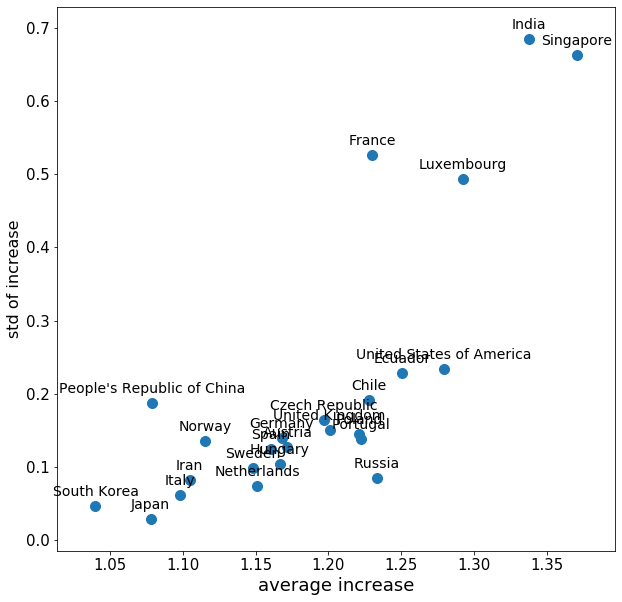

In [71]:
ax = finaldata.plot.scatter(x='average',y='std',s=100,figsize=(10,10), fontsize=15)

xs = finaldata['average'].values
ys = finaldata['std'].values
country = finaldata['country']

plt.xlabel('average increase', fontsize=18)
plt.ylabel('std of increase', fontsize=16)

# zip joins x and y coordinates in pairs
for x,y,label in zip(xs,ys,country):

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize=14) # horizontal alignment can be left, right or center


plt.show()
